# Final Project: EyeCheck.AI_ResNet50
- **Nama:** Muhammad Giat
- **NPM:** 140810210013
- **Email:** muhammad21019@mail.unpad.ac.id

In [37]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


# Import Library

In [38]:
# Import Libraries
import numpy as np
import random
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import cv2
import os
import itertools
from imutils import paths
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

import warnings
warnings.filterwarnings("ignore")

# Menyiapkan Dataset

In [39]:
# Menentukan path untuk training validating, dan testing dataset
training_path = r"D:/Skripsi - Tugas Akhir/Skripsi-Coding/training"
print(f"List nama folder pada dataset training:\n{os.listdir(training_path)}")

validate_path = r"D:/Skripsi - Tugas Akhir/Skripsi-Coding/validasi"
print(f"List nama folder pada dataset validasi:\n{os.listdir(validate_path)}")

test_path = r"D:/Skripsi - Tugas Akhir/Skripsi-Coding/testing"
print(f"List nama folder pada dataset testing:\n{os.listdir(test_path)}")

List nama folder pada dataset training:
['bulging_eyes', 'cataracts', 'crossed_eyes', 'normal_eyes', 'uveitis']
List nama folder pada dataset validasi:
['bulging_eyes', 'cataracts', 'crossed_eyes', 'normal_eyes', 'uveitis']
List nama folder pada dataset testing:
['bulging_eyes', 'cataracts', 'crossed_eyes', 'normal_eyes', 'uveitis']


In [40]:
# Menentukan ukuran target untuk gambar dan label penyakit mata
target_image_size = (240, 240)
eye_disease_labels = {
    "bulging_eyes": 0,
    "cataracts": 1,
    "crossed_eyes": 2,
    "normal_eyes": 3,
    "uveitis": 4
}

# Fungsi untuk Memuat & Visualisasi Dataset

In [41]:
# Fungsi untuk memuat dataset
def load_image_dataset(data_path, target_image_size, dict_labels, shuffle_data=True):
    x = []
    labels = []
    image_paths = sorted(list(paths.list_images(data_path)))
    for image_path in image_paths:
        img = cv2.imread(image_path)
        img = cv2.resize(img, target_image_size)
        x.append(img)
        label = image_path.split(os.path.sep)[-2]
        labels.append(dict_labels[label])
    if shuffle_data:
        x, labels = shuffle(x, labels, random_state=42)
    input_shape = (target_image_size[0], target_image_size[1], 3)
    return x, labels, input_shape

In [42]:
# Memuat training dataset dengan shuffling
x_train, y_train, input_shape = load_image_dataset(training_path, target_image_size, eye_disease_labels, shuffle_data=True)

# Memuat validating dataset dengan shuffling
x_val, y_val, _ = load_image_dataset(validate_path, target_image_size, eye_disease_labels, shuffle_data=True)

# Memuat testing dataset tanpa shuffling
x_test, y_test, _ = load_image_dataset(test_path, target_image_size, eye_disease_labels, shuffle_data=False)

In [43]:
# Output Data untuk training dataset
print(f"Training Data\n1. X shape\t: {np.array(x_train).shape}")
print(f"2. Total Class\t: {len(np.unique(y_train))}")
print(f"3. Total Data\t: {len(y_train)}")
print(f"4. Input Shape\t: {input_shape}")

Training Data
1. X shape	: (2176, 240, 240, 3)
2. Total Class	: 5
3. Total Data	: 2176
4. Input Shape	: (240, 240, 3)


In [44]:
# Hitung jumlah data per label pada training dataset
unique, counts = np.unique(y_train, return_counts=True)
print(f"Data Training per Label:")
for i, (label, count) in enumerate(eye_disease_labels.items()):
    print(f"\t{label}\t: {counts[i]}")

print(f"Total Data Training\t: {len(y_train)}")

# Visualisasi bar chart dengan plotly data training dataset per label
# Define custom colors for each label
colors = ['blue', 'orange', 'purple', 'green', 'red'] 

fig = go.Figure(data=[go.Bar(
    x=list(eye_disease_labels.keys()),
    y=counts,
    marker_color=colors,  # Assign colors to bars
    text=counts,  # Add text labels
    textposition='auto'  
)])
fig.update_layout(
    title_text="Data Training per Label",
    xaxis_title="Label",
    yaxis_title="Jumlah Data",
    xaxis_tickangle=-45,  # Rotate x-axis labels for better readability
)
fig.show()


Data Training per Label:
	bulging_eyes	: 243
	cataracts	: 462
	crossed_eyes	: 381
	normal_eyes	: 430
	uveitis	: 660
Total Data Training	: 2176


In [45]:
# Output untuk validation dataset
print(f"\nValidation Data\n1. X shape\t: {np.array(x_val).shape}")
print(f"2. Total Class\t: {len(np.unique(y_val))}")
print(f"3. Total Data\t: {len(y_val)}")
print(f"4. Input Shape\t: {input_shape}")


Validation Data
1. X shape	: (364, 240, 240, 3)
2. Total Class	: 5
3. Total Data	: 364
4. Input Shape	: (240, 240, 3)


In [46]:
# Hitung jumlah data per label pada validating dataset
unique, counts = np.unique(y_val, return_counts=True)
print(f"Data Validating per Label:")
for i, (label, count) in enumerate(eye_disease_labels.items()):
    print(f"\t{label}\t: {counts[i]}")

print(f"Total Data Validating\t: {len(y_val)}")

# Visualisasi bar chart dengan plotly data validating dataset per label
# Define custom colors for each label
colors = ['blue', 'orange', 'purple', 'green', 'red'] 

fig = go.Figure(data=[go.Bar(
    x=list(eye_disease_labels.keys()),
    y=counts,
    marker_color=colors,  # Assign colors to bars
    text=counts,  # Add text labels
    textposition='auto'  
)])
fig.update_layout(
    title_text="Validating per Label",
    xaxis_title="Label",
    yaxis_title="Jumlah Data",
    xaxis_tickangle=-45,  # Rotate x-axis labels for better readability
)
fig.show()

Data Validating per Label:
	bulging_eyes	: 53
	cataracts	: 62
	crossed_eyes	: 61
	normal_eyes	: 46
	uveitis	: 142
Total Data Validating	: 364


In [47]:
# Output untuk testing dataset
print(f"Testing Data\n1. X shape\t: {np.array(x_test).shape}")
print(f"2. Total Class\t: {len(np.unique(y_test))}")
print(f"3. Total Data\t: {len(y_test)}")
print(f"4. Input Shape\t: {input_shape}")

Testing Data
1. X shape	: (100, 240, 240, 3)
2. Total Class	: 5
3. Total Data	: 100
4. Input Shape	: (240, 240, 3)


In [48]:
# Hitung jumlah data per label pada testing dataset
unique, counts = np.unique(y_test, return_counts=True)
print(f"Data Testing per Label:")
for i, (label, count) in enumerate(eye_disease_labels.items()):
    print(f"\t{label}\t: {counts[i]}")

print(f"Total Data Testing\t: {len(y_test)}")

# Visualisasi bar chart dengan plotly data testing dataset per label
# Define custom colors for each label
colors = ['blue', 'orange', 'purple', 'green', 'red'] 

fig = go.Figure(data=[go.Bar(
    x=list(eye_disease_labels.keys()),
    y=counts,
    marker_color=colors,  # Assign colors to bars
    text=counts,  # Add text labels
    textposition='auto'  
)])
fig.update_layout(
    title_text="Data Testing per Label",
    xaxis_title="Label",
    yaxis_title="Jumlah Data",
    xaxis_tickangle=-45,  # Rotate x-axis labels for better readability
)
fig.show()

Data Testing per Label:
	bulging_eyes	: 18
	cataracts	: 23
	crossed_eyes	: 22
	normal_eyes	: 21
	uveitis	: 16
Total Data Testing	: 100


# Fungsi untuk Visualisasi Gambar Dataset

In [49]:
# Fungsi visualisasi gambar dengan label
def image_vizualize(batch_image, labels, num_image, eye_disease_labels):
    plt.figure(figsize=(15, 18))
    
    # Ambil acak indeks untuk memilih gambar
    index = random.sample(range(len(batch_image)), num_image)
    
    for i, n in enumerate(index):
        # Convert BGR ke RGB
        rgb_image = cv2.cvtColor(batch_image[n], cv2.COLOR_BGR2RGB)
        
        plt.subplot(num_image // 5 + 3, 5, i + 1)
        plt.imshow(rgb_image)
        plt.axis('off')
        img_height, img_width, _ = batch_image[n].shape
        plt.title(np.array(list(eye_disease_labels.keys()))[to_categorical(labels, num_classes=len(np.unique(labels)))[n] == 1][0].title() + f'\n({img_width}px x {img_height}px)')
        plt.subplots_adjust(hspace=0.5)

    plt.tight_layout()
    plt.show()

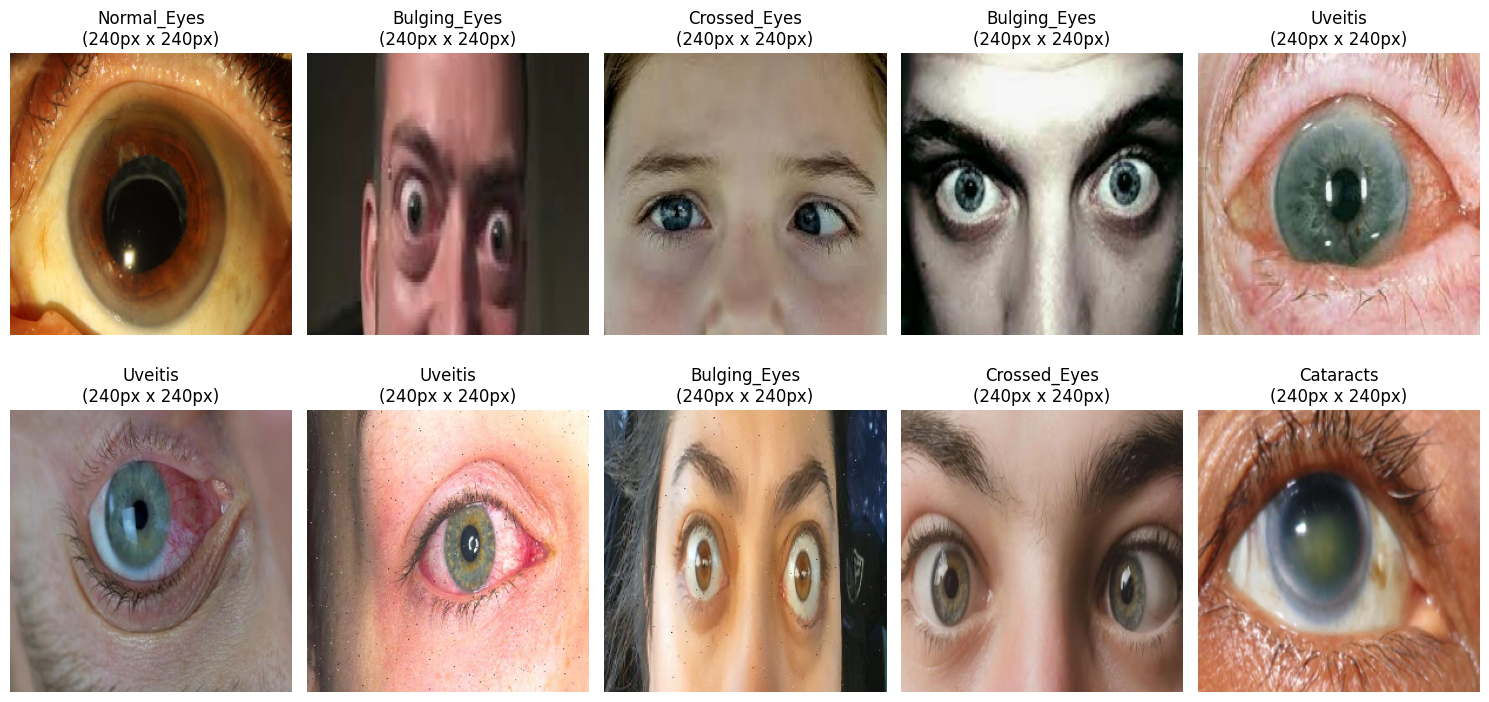

In [50]:
# Visualisasi 10 Dataset Secara Random
image_vizualize(x_train, y_train, 10, eye_disease_labels)

# Fungsi untuk Mempersiapkan Data untuk CNN

In [51]:
# Fungsi mempersiapkan data untuk training CNN
def data_preparation_training(training_path, validate_path, test_path, target_image_size):
    training = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    fill_mode='nearest',
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
    )
    
    training_generator = training.flow_from_directory(
        directory=training_path,
        target_size=target_image_size,
        batch_size=32,
        class_mode="categorical",
        classes=["bulging_eyes", "cataracts", "crossed_eyes", "normal_eyes", "uveitis"],
        shuffle=True
    )
    
    validate = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
        fill_mode='nearest',
        horizontal_flip=True,
        vertical_flip=False
    )

    validate_generator = validate.flow_from_directory(
        directory=validate_path,
        target_size=target_image_size,
        batch_size=32,
        class_mode="categorical",
        classes=["bulging_eyes", "cataracts", "crossed_eyes", "normal_eyes", "uveitis"],
        shuffle=True
    )

    test = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.resnet50.preprocess_input
    )

    test_generator = test.flow_from_directory(
        directory=test_path,
        target_size=target_image_size,
        batch_size=32,
        classes=["bulging_eyes", "cataracts", "crossed_eyes", "normal_eyes", "uveitis"],
        class_mode="categorical",
        shuffle=False
    )
    
    return training_generator, validate_generator, test_generator


In [52]:
# Panggil fungsi data_preparation_training
training_generator, validate_generator, test_generator = data_preparation_training(training_path, validate_path, test_path, target_image_size)

Found 2176 images belonging to 5 classes.
Found 364 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


# Fungsi untuk Generate Data dan Train Model

In [53]:
# Fungsi untuk training model menggunakan ResNet50 dengan generator
def training_model(training_generator, validate_generator, epochs=30):
    
    # Menggunakan Adam optimizer dengan learning rate lebih rendah
    optimizer = Adam(learning_rate=1e-5)

    # Base model
    base_model = ResNet50(
        input_shape=(240, 240, 3),
        include_top=False,
        weights='imagenet'
    )
    
    # Membuat layer pada base_model menjadi tidak dapat dilatih
    for layer in base_model.layers:
        layer.trainable = False

    # Model architecture
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(units=256, activation='relu'),
        Dense(units=512, activation='relu'),
        Dropout(0.2), 
        Dense(units=5, activation='softmax')
    ])
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=8, 
        restore_best_weights=True, 
        verbose=1
    )
    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=3, 
        verbose=1
    )

    # Training
    history = model.fit(
        training_generator,
        validation_data=validate_generator,
        epochs=epochs,
        verbose=1,
        steps_per_epoch=len(training_generator),
        validation_steps=len(validate_generator),
        callbacks=[early_stopping, lr_scheduler]
    )
    return history, model

In [54]:
# List kosong untuk menyimpan values
training_metrics = []
validate_metrics = []
all_classification_reports = []
all_confusion_matrix = []

In [55]:
# Train the model
history, trained_model = training_model(training_generator, validate_generator, epochs=30)

Epoch 1/30
68/68 [==============================] - 32s 431ms/step - loss: 1.4405 - accuracy: 0.3658 - val_loss: 1.1189 - val_accuracy: 0.6044 - lr: 1.0000e-05
Epoch 2/30
68/68 [==============================] - 28s 409ms/step - loss: 1.0088 - accuracy: 0.6875 - val_loss: 0.8418 - val_accuracy: 0.7582 - lr: 1.0000e-05
Epoch 3/30
68/68 [==============================] - 27s 395ms/step - loss: 0.7569 - accuracy: 0.7937 - val_loss: 0.6575 - val_accuracy: 0.8297 - lr: 1.0000e-05
Epoch 4/30
68/68 [==============================] - 28s 410ms/step - loss: 0.6111 - accuracy: 0.8364 - val_loss: 0.5380 - val_accuracy: 0.8626 - lr: 1.0000e-05
Epoch 5/30
68/68 [==============================] - 27s 394ms/step - loss: 0.4997 - accuracy: 0.8644 - val_loss: 0.4537 - val_accuracy: 0.8901 - lr: 1.0000e-05
Epoch 6/30
68/68 [==============================] - 27s 401ms/step - loss: 0.4356 - accuracy: 0.8768 - val_loss: 0.3919 - val_accuracy: 0.9011 - lr: 1.0000e-05
Epoch 7/30
68/68 [======================

In [56]:
# Collect metrics
training_metrics.append(history.history['accuracy'])
validate_metrics.append(history.history['val_accuracy'])

# Get predictions and true labels for validation data
validation_predictions = trained_model.predict(validate_generator, steps=len(validate_generator), verbose=1)
validation_predictions = np.argmax(validation_predictions, axis=1)
validation_labels = validate_generator.classes 

# Generate and store classification report and confusion matrix
classification_report_str = classification_report(validation_labels, validation_predictions, target_names=list(eye_disease_labels.keys()))
confusion_mtx = confusion_matrix(validation_labels, validation_predictions)


all_classification_reports.append(classification_report_str)
all_confusion_matrix.append(confusion_mtx)

12/12 [==============================] - 3s 178ms/step


# Prediksi dan Simpan Hasil

In [57]:
# Fungsi untuk menyimpan hasil classification report dalam bentuk gambar
def save_classification_report_image(classification_report_str, destination_dir, is_final=False):
    if not is_final:
        plt_title = "Classification Report"
    else:
        plt_title = "Final Classification Report"

    full_path = os.path.join(destination_dir, f'{plt_title.lower().replace(" ", "_")}.png')
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    plt.figure(figsize=(8, 6))
    plt.text(0.2, 0.7, classification_report_str, fontsize=12, verticalalignment='center')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(full_path, bbox_inches='tight')
    plt.close()

# Fungsi untuk menyimpan hasil confusion matrix
def save_confusion_matrix_image(confusion_mtx, destination_dir, is_final=False):
    if not is_final:
        plt_title = "Confusion Matrix"
    else:
        plt_title = "Final Confusion Matrix"

    full_path = os.path.join(destination_dir, f'{plt_title.lower().replace(" ", "_")}.png')
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    plt.figure(figsize=(8, 6))
    plt.imshow(confusion_mtx, interpolation="nearest", cmap=plt.cm.Oranges)
    plt.title(plt_title)
    plt.colorbar()
    tick_marks = np.arange(len(eye_disease_labels.keys()))
    plt.xticks(tick_marks, eye_disease_labels.keys(), rotation=45, ha='right')
    plt.yticks(tick_marks, eye_disease_labels.keys())
    fmt = ".2f" if False else "d"
    thresh = confusion_mtx.max() / 2.
    for i, j in itertools.product(range(confusion_mtx.shape[0]), range(confusion_mtx.shape[1])):
        plt.text(j, i, format(confusion_mtx[i, j], fmt), horizontalalignment="center",
                color="white" if confusion_mtx[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel("True Labels", fontweight="bold")
    plt.xlabel("Predicted Labels", fontweight="bold")
    plt.savefig(full_path, bbox_inches='tight')
    plt.close()

# Fungsi untuk menyimpan plot Training dan Validation Accuracy
def save_training_validation_accuracy(history, destination_dir):
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)
    
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    accuracy_plot_path = os.path.join(destination_dir, 'training_validation_accuracy.png')
    plt.savefig(accuracy_plot_path)
    plt.close()

# Fungsi untuk menyimpan plot Training dan Validation Loss
def save_training_validation_loss(history, destination_dir):
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)
    
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    loss_plot_path = os.path.join(destination_dir, 'training_validation_loss.png')
    plt.savefig(loss_plot_path)
    plt.close()

In [58]:
# Folder penyimpanan untuk classification report
destination_dir_classification = r"D:/Skripsi - Tugas Akhir/Skripsi-Coding/TestResnet50/1BB"

# Folder penyimpanan untuk confusion matrix
destination_dir_confusion = r"D:/Skripsi - Tugas Akhir/Skripsi-Coding/TestResnet50/1BB"

# Folder penyimpanan untuk grafik akurasi dan loss
destination_dir_plots = r"D:/Skripsi - Tugas Akhir/Skripsi-Coding/TestResnet50/1BB"

In [59]:
# Simpan classification reports sebagai gambar
for i, classification_report_str in enumerate(all_classification_reports):
    save_classification_report_image(classification_report_str, destination_dir_classification, is_final=False)

In [60]:
# Simpan confusion matrices sebagai gambar
for i, confusion_mtx in enumerate(all_confusion_matrix):
    save_confusion_matrix_image(confusion_mtx, destination_dir_confusion, is_final=False)

In [61]:
# Lakukan prediksi pada data test dengan generator
test_predictions = trained_model.predict(test_generator, steps=len(test_generator), verbose=1)
test_predictions = np.argmax(test_predictions, axis=1)

4/4 [==============================] - 1s 181ms/step


In [62]:
# Hitung dan cetak classification report akhir
test_labels = test_generator.classes
final_classification_report = classification_report(test_labels, test_predictions, target_names=list(eye_disease_labels.keys()))
print(f"Final Classification Report\n")
print(final_classification_report)


Final Classification Report

              precision    recall  f1-score   support

bulging_eyes       1.00      0.89      0.94        18
   cataracts       1.00      0.91      0.95        23
crossed_eyes       0.88      0.95      0.91        22
 normal_eyes       1.00      1.00      1.00        21
     uveitis       0.89      1.00      0.94        16

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100



In [63]:
# Simpan classification report akhir sebagai gambar
save_classification_report_image(final_classification_report, destination_dir_classification, is_final=True)

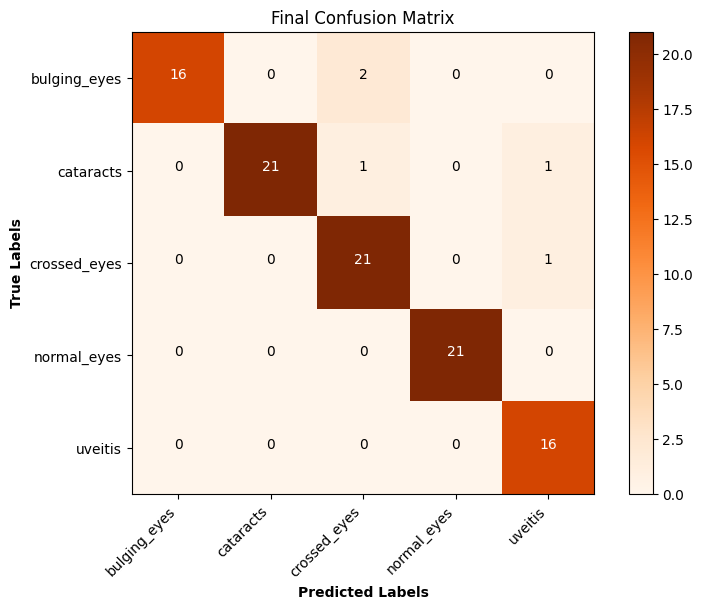

In [64]:
# Final confusion matrix
final_confusion_mtx = confusion_matrix(test_labels, test_predictions)

# Plot final confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(final_confusion_mtx, interpolation="nearest", cmap=plt.cm.Oranges)
plt.title("Final Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(eye_disease_labels.keys()))
plt.xticks(tick_marks, eye_disease_labels.keys(), rotation=45, ha='right')
plt.yticks(tick_marks, eye_disease_labels.keys())
fmt = ".2f" if False else "d"
thresh = final_confusion_mtx.max() / 2.
for i, j in itertools.product(range(final_confusion_mtx.shape[0]), range(final_confusion_mtx.shape[1])):
    plt.text(j, i, format(final_confusion_mtx[i, j], fmt), horizontalalignment="center",
             color="white" if final_confusion_mtx[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel("True Labels", fontweight="bold")
plt.xlabel("Predicted Labels", fontweight="bold")
plt.show()

In [65]:
# Simpan final confusion matrix sebagai gambar
final_confusion_mtx = confusion_matrix(test_labels, test_predictions)
save_confusion_matrix_image(final_confusion_mtx, destination_dir_confusion, is_final=True)

In [66]:
# Fungsi untuk menampilkan plot Training dan Validation Accuracy
def plot_training_validation_accuracy(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

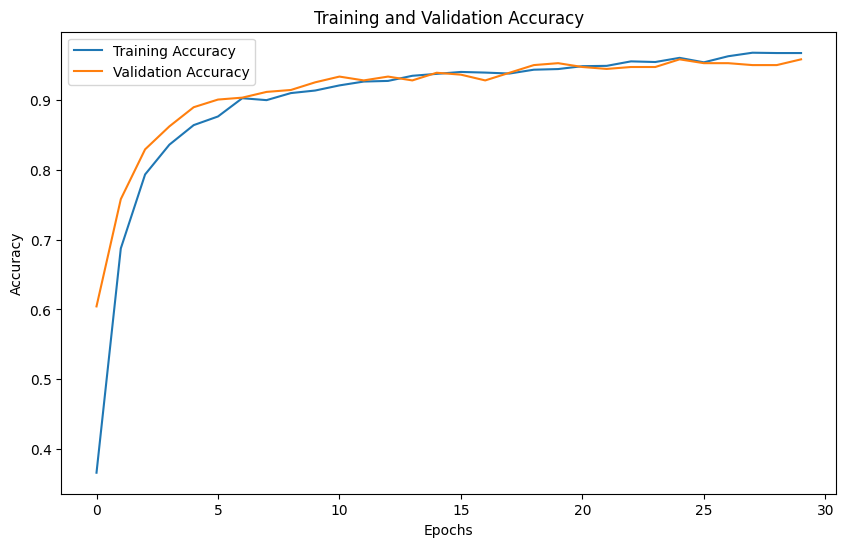

In [67]:
# Panggil fungsi untuk menampilkan plot Training dan Validation Accuracy
plot_training_validation_accuracy(history)

In [68]:
# Fungsi untuk menampilkan plot Training dan Validation Loss
def plot_training_validation_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

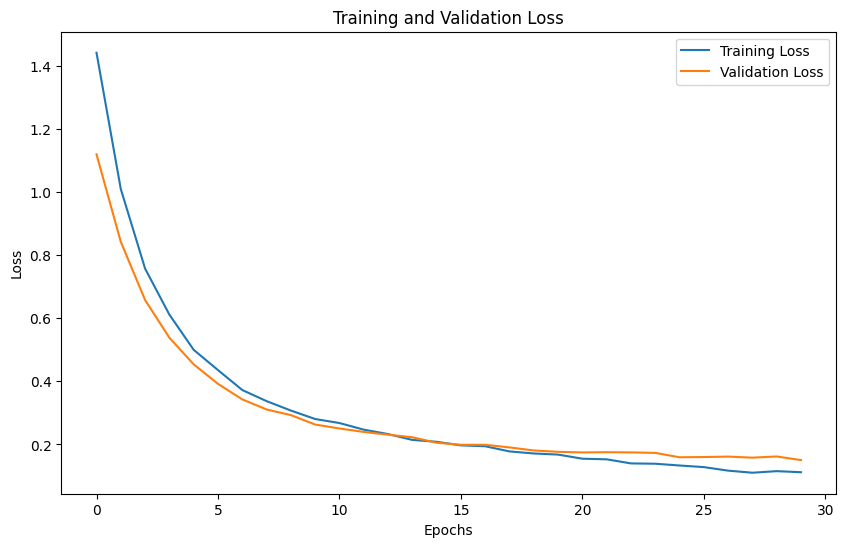

In [69]:
# Panggil fungsi untuk menampilkan plot Training dan Validation Loss
plot_training_validation_loss(history)

In [70]:
# Menyimpan plot training_validasi_loss sebagai gambar
save_training_validation_accuracy(history, destination_dir_plots)
save_training_validation_loss(history, destination_dir_plots)

# Simpan Model

In [ ]:
Save model
trained_model.save("D:/Skripsi - Tugas Akhir/Skripsi-Coding/Model Test Resnet50/model_Resnet50_F.h5")
print("Model telah berhasil disimpan")

In [ ]:
# Tampilkan berat model
print(f"Berat model Resnet50: {os.path.getsize('D:/Skripsi - Tugas Akhir/Skripsi-Coding/model_Resnet50.h5') / 1e6:.2f} MB")